### Prophet with Linear Dependencies on Features

In this notebook we investigate whether linear dependency of external parameters on 'y' can be inferred with this forecasting algorthm.

[]

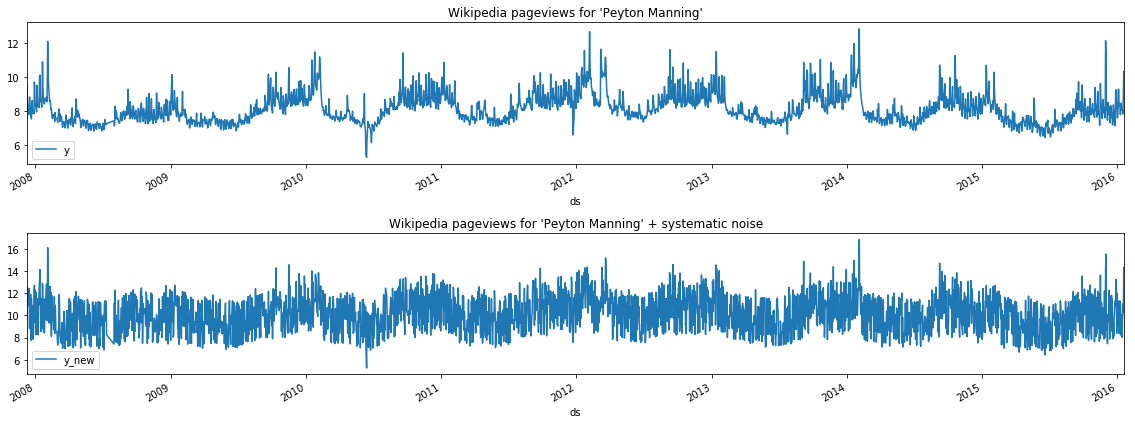

In [19]:
%matplotlib inline

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import theano
import theano.tensor as tt
from fbprophet import Prophet

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

df = pd.read_csv('peyton_manning.csv')
# Make sure we work with datetime types
df['ds'] = pd.to_datetime(df['ds'])
# Scale the data
df['y_scaled'] = df['y'] / df['y'].max()
df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())
df.plot(x='ds', y='y', figsize=(16, 6), 
        title="Wikipedia pageviews for 'Peyton Manning'", ax=ax[0])

df['ext_1'] = pd.Series(np.random.randint(0, 5, df.shape[0]))
df['y_new'] = df['y'] + df['ext_1']
df['y_new_scaled'] = df['y_new'] / df['y_new'].max()

df.plot(x='ds', y='y_new', figsize=(16, 6), title="Wikipedia pageviews for 'Peyton Manning' + systematic noise", ax=ax[1])
plt.tight_layout()
plt.plot()

In [14]:
# same logic as before
def growth_model(model,
                 scaled_time,
                 n_changepoints=125,
                 growth_prior_scale=5,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8
                ):
    
    # changepoints spread uniformly between 0 and 0.8 of history
    s = np.linspace(0, changepoint_range*np.max(scaled_time), n_changepoints+1)[1:]
    A = (scaled_time.reshape(-1, 1) > s)*1
    
    with model:
        k = pm.Normal('k', mu=0, sd=growth_prior_scale)
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        m = pm.Normal('m', mu=0, sd=5)
        gamma = -s * delta

        growth_func = (k + tt.dot(A, delta)) * scaled_time + (m + tt.dot(A, gamma))
        
    return growth_func, A, s

def seasonality_model(model, 
                      t, 
                      order=10, 
                      period=365.25,
                      seasonality_prior_scale=10
                     ):
    # IMP: We are working in normalized time.
    period = period / (df['ds'].max() - df['ds'].min()).days
    tmp = (2 * np.pi/period) * np.arange(1, order+1)
    tmp = tmp * t[:, None]
    tmp = np.concatenate((np.cos(tmp), np.sin(tmp)), axis=1)
    
    with model:
        beta = pm.Normal('beta', 0, seasonality_prior_scale, shape=2*order)
        year_season = tt.dot(tmp, beta)
        
    return tmp, year_season

def ext_impact_model(model, t):
    with model:
        alpha = pm.Normal('alpha', 3, 4)
        delta_y = tt.dot(alpha, df['ext_1'])
        
    return delta_y
    
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

def det_season(base, beta):
    return base @ beta

with pm.Model() as model:
    y_growth, A, s = growth_model(model, df['t'].values)
    base, y_yearly = seasonality_model(model, df['t'].values)
    delta_y = ext_impact_model(model, df['t'].values)
    
    y = y_growth + y_yearly + delta_y
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    y_obs = pm.Normal('y_obs', mu=y, sd=sigma, observed=df['y_new_scaled'])
    # trace = pm.sample(init='adapt_diag')
    map_trace = pm.find_MAP(model=model)

growth_map = det_trend(map_trace['k'], map_trace['m'], map_trace['delta'], df['t'], s, A) * df['y_new'].max()
season_map = det_season(base, map_trace['beta']) * df['y_new'].max()

/Users/paresh/.pyenv/versions/3.6.8/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 6,149.9, ||grad|| = 218.69: 100%|██████████| 850/850 [00:02<00:00, 296.98it/s] 


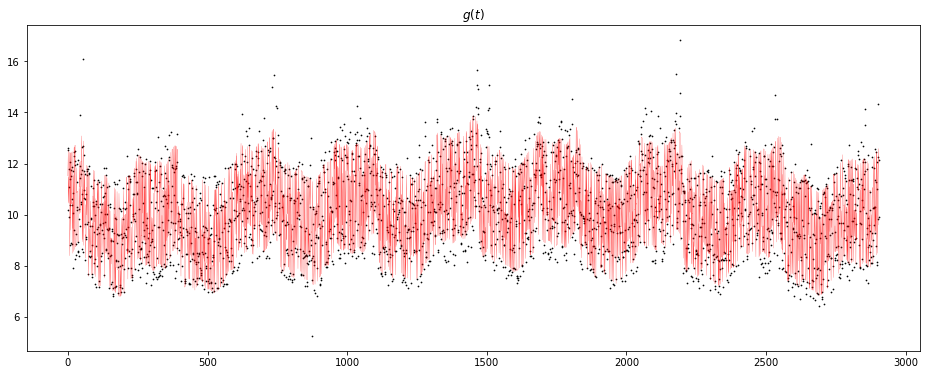

In [17]:
linear_impact = (map_trace['alpha'] * df['ext_1']) * df['y_new'].max()

plt.figure(figsize=(16, 6))
plt.title('$g(t)$')
plt.plot(growth_map+season_map+linear_impact, 'r', linewidth=0.2)
# plt.plot(g, 'b')
plt.scatter(np.arange(df.shape[0]), df.y_new, s=0.5, color='black')
plt.show()

In [18]:
# ideally this should have been 1
map_trace['alpha']

array(0.0598607)

### Some Comments

1. The forcasting algorithm did a pretty good job fitting a curve to our artificial data.
2. The value of alpha inferred however is far too low compared to the value used to generate the data.
3. Why? If we add systematic noise to the data, the inference algorithm cannot decide clearly whether the observed data is indeed *real* or is the result of data together with systematic noise. The curve fitting mechanism is so powerful that it returns us a curve that matches the data pretty well, assuming that this is the real data. It seems that unless there is a very strong correlation between our external parameters out y_new, the inference algorithm would not be able to figure it out.